In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from trainer import *
from results import Results
set_seaborn()
FIG_SIZE = (12, 6)
sns.set_theme(rc={'figure.figsize': FIG_SIZE})


In [72]:
import scipy
import numpy as np
from tools import *


def build_train_test_hankels(X, Y, dim, test_start, train_test_ratio):

    start = int(len(X) * test_start)
    end = start + int(len(X) * train_test_ratio)

    X_test, Y_test = X[start:end],  Y[start:end]
    X_train, Y_train = X.copy(), Y.copy()

    # use to remove from hankel later
    X_train[start:end] = np.nan

    # remove the beginning for causal convoltuion
    Y_train = np.delete(Y_train, np.arange(0, dim))
    Y_test = np.delete(Y_test, np.arange(0, dim))

    test_hankel = build_hankel(X_test, dim)
    train_hankel = build_hankel(X_train, dim)

    # remove lag vector with nan
    nan_cols = np.bitwise_or.reduce(np.isnan(train_hankel), 0)

    train_hankel = np.delete(train_hankel, nan_cols, axis=1)
    Y_train = np.delete(Y_train, nan_cols)

    return train_hankel, Y_train, test_hankel, Y_test


def train_test_method(X, Y, model, dims, train_test_ratio=0.2, beta=1e-8):

    test_start_range = np.linspace(0.0, 1.0-train_test_ratio, 100)
    T = len(test_start_range)
    B = len(dims)

    train_errors = np.zeros((B, T))
    test_errors = np.zeros((B, T))
    filters = np.zeros((B, T), dtype='O')
    all_params = np.zeros((B, T), dtype='O')
    for b, dim in enumerate(dims):
        for t, test_start in enumerate(test_start_range):

            train_hankel, Y_train, test_hankel, Y_test = build_train_test_hankels(
                X, Y, dim, test_start, train_test_ratio)
            
            P_train, theta, params = model.train(
                train_hankel, Y_train, dim, beta=beta)
            P_test = model.test(test_hankel, theta, params)
            train_err = mean_square_error(Y_train, P_train)
            test_err = mean_square_error(Y_test, P_test)

            train_errors[b, t] = train_err
            test_errors[b, t] = test_err
            filters[b, t] = theta
            all_params[b, t] = params

    return train_errors, test_errors, filters, all_params, dims


In [73]:
resPH, stimPH = read_lmc('PHOTO')
res1, stim3 = read_lmc('LMC-BG1')

In [74]:
data_str = 'LMC-BG1'
d_method = 'mean'
dt_ms = 2.0
lags = [20,30,40,50,60]#np.arange(20,130,10)
dims = []
for l in lags:
    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, l)
    dims.append(dim)

X = preprocess(resPH, factor=factor, method=d_method)
Y = preprocess(res1, factor=factor, method=d_method)
title = f'{data_str} dT={dt_ms}ms'

all_results = []

model = ConstantModel(f'Identity {title}')
res = train_test_method(X, Y, model, np.ones_like(dims))
C2_Results = Results(model.name, *res)

model = LinearModel(f'Linear {title}')
res = train_test_method(X, Y, model, dims)
Lin50_Results = Results(model.name, *res)


model = EigenTimeModel(f'Eigen-Time {title}')
res = train_test_method(X, Y, model, dims)
EigTime_Results = Results(model.name, *res)

model = EigenCShiftTimeModel(
    f'Eigen-CShift-Time {title}', window_factor=2.0)
res = train_test_method(X, Y, model, dims)
EigenCShiftTime_Results = Results(model.name, *res)

cur_results = [C2_Results, Lin50_Results, EigTime_Results, EigenCShiftTime_Results]


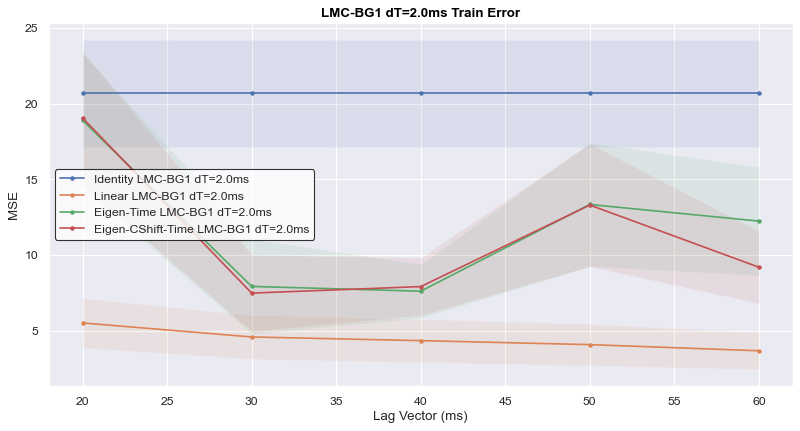

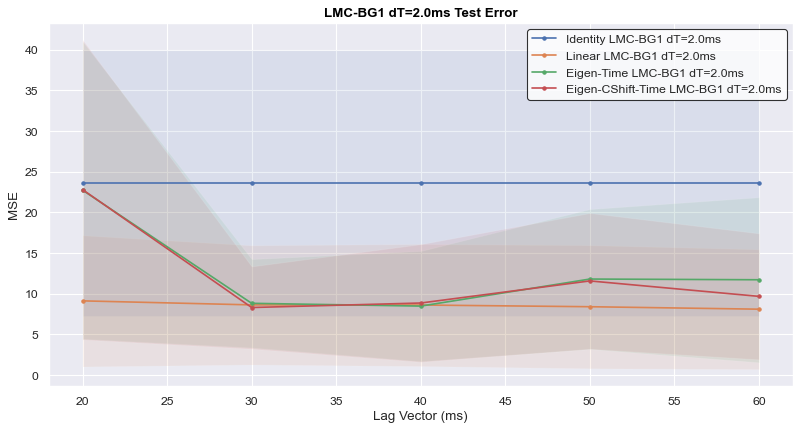

In [75]:
for i, result in enumerate(cur_results):
    (err, std), l = result.get_train_errs(), result.name
    plt.plot(lags, err, '.-', label=l)
    plt.fill_between(lags, err-std, err+std, alpha=0.1)

plt.legend()
plt.ylabel('MSE')
plt.xlabel('Lag Vector (ms)')
plt.title(f'{title} Train Error')
plt.show()



for i, result in enumerate(cur_results):
    (err, std), l = result.get_test_errs(), result.name
    plt.plot(lags, err, '.-', label=l)
    plt.fill_between(lags, err-std, err+std, alpha=0.1)

plt.legend()
plt.ylabel('MSE')
plt.xlabel('Lag Vector (ms)')
plt.title(f'{title} Test Error')
plt.show()




In [76]:
Linerr, std = Lin50_Results.get_opt_test_err()
print('LinErr Best Error: ', Linerr)
Eigerr, std = EigTime_Results.get_opt_test_err()
print('EigTimeErr Best Error: ', Eigerr)
Eigerr, std = EigenCShiftTime_Results.get_opt_test_err()
print('EigTimeCErr Best Error: ', Eigerr)

LinErr Best Error:  8.102122524279102
EigTimeErr Best Error:  8.480240632845623
EigTimeCErr Best Error:  8.30654703351804
